In [8]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(subfig, A, B, C0, C1, mindist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([A[0], B[0]])-fudgeX,np.max([A[0], B[0]])+fudgeX))
    subfig.set_ylim((np.min([A[1], B[1]])-fudgeY_neg,np.max([A[1], B[1]])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([A[0], B[0]],[A[1], B[1]],c="red",linewidths=0)
    line_AB = plt.Line2D([A[0], B[0]],[A[1], B[1]], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle(A,min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle(B,min_dist,color='g',alpha=0.5)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=A[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=B[0:2],xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C0[0],C1[0]],[C0[1],C1[1]],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=C0[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=C1[0:2],xytext=(3,4),textcoords="offset points")


In [20]:
min_dist = 1                    # let's set a minimum distance of 1m
A  = np.array([0,0,0])     # person A position
B  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([2.1,-0.2,0])    # Ending camera position

def sigmoid_blended_trajectory(A, B, C0, C1, min_dist, blendOptimizer):
    
    '''
    This function sets up the problem, and passes in the individual trajectories
    to the given blendOptimizer function. 
    
    blendOptimizer must return a blended trajectory as well as a blending function.
    
    We then draw it all pretty.
    '''
    
    # Set up interpolation vector
    u = np.c_[np.linspace(0,1)]

    # Set up the distance components of sigmaA, sigmaB
    dA0 = la.norm(C0 - A)
    dA1 = la.norm(C1 - A)
    dB0 = la.norm(C0 - B)
    dB1 = la.norm(C1 - B)

    dA = np.linspace(dA0, dA1)
    dB = np.linspace(dB0, dB1)

    # Set up the vantage vector components of sigmaA, sigmaB
    vA0 = (C0 - A) / dA0
    vA1 = (C1 - A) / dA1
    vB0 = (C0 - B) / dB0
    vB1 = (C1 - B) / dB1

    vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
    vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

    # Set up sigmaA, sigmaB, sigma
    sigmaA = A + dA[:,np.newaxis] * vA
    sigmaB = B + dB[:,np.newaxis] * vB

    sigmaAvg = (sigmaA + sigmaB)/2
    wA, sigmaBlended = blendOptimizer(u, sigmaA, sigmaB, A, B)

    # Drawing Code
    
    pylab.rcParams['figure.figsize'] = 16, 8
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])

    drawSetup(f1, A, B, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(4+min_dist),fudgeX=1+min_dist)
    f1.plot(sigmaA[:,0],       sigmaA[:,1],       c="green")
    f1.plot(sigmaB[:,0],       sigmaB[:,1],       c="blue")
    f1.plot(sigmaAvg[:,0],     sigmaAvg[:,1],     c="red")
    f1.plot(sigmaBlended[:,0], sigmaBlended[:,1], c="purple")

    f1.set_title("World Space Trajectories")

    sA_legend = mpatches.Patch(color="green", label="sigmaA")
    sB_legend = mpatches.Patch(color="blue", label="sigmaB")
    SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
    SW_legend  = mpatches.Patch(color="purple", label="sigma Blended")

    f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])
    
    
    f2.plot(wA)
    f2.set_title("Weighing function")


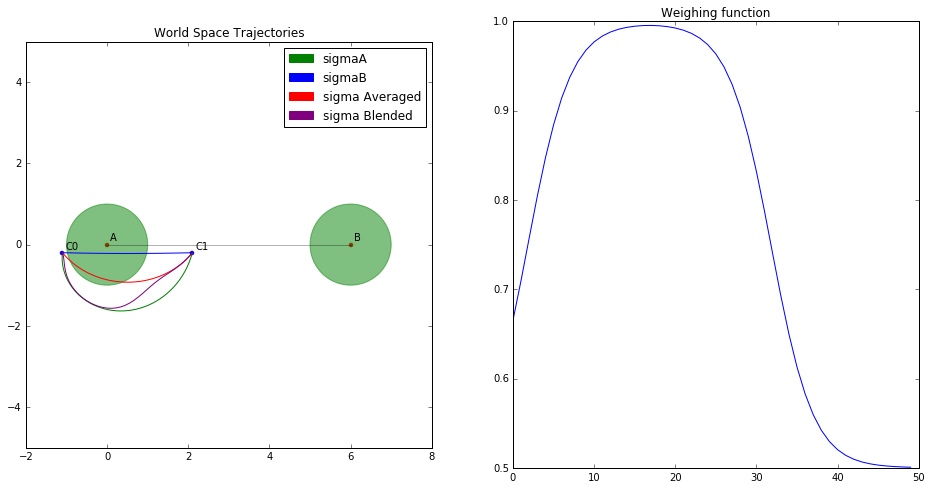

In [24]:
def blendOptimizer_simple_sigmoid_blend(u, sigma_i, sigma_j, i, j):
    '''
    This blending function implements the a soft version of the constraints
    represented in notebook "09 - NJ" directly: we are not minimizing anything explicitly.
    '''
    from scipy.special import expit

    scale = 6

    def silly_map(sigmas):
        sigmaiu = sigmas[0:3]
        sigmaju = sigmas[3:6]

        w1 = expit(-scale*(la.norm(sigmaju - i) - min_dist))/2 + 0.5 #weight one goes from 1 to 0.5
        w2 = expit(scale*(la.norm(sigmaiu - j) - min_dist))
        return w1*w2

    blend = np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer_simple_sigmoid_blend)

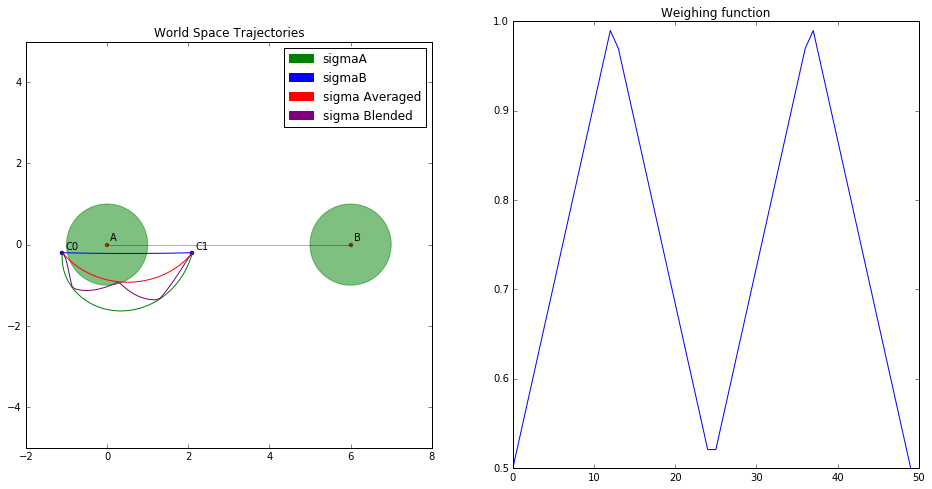

In [25]:

from scipy import interpolate

def blendOptimizer_silly_by_hand(u, sigma_i, sigma_j, i, j):
    f = interpolate.interp1d([0,0.25,0.5,0.75,1],[0.5,1,0.5,1,0.5])
    blend = f(u)
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer_silly_by_hand)

# Blending function properties and constraints

We want to find $w_A(\vec{\sigma}_A,\vec{\sigma}_B,u)$ such that 

$$
\vec{\sigma}(u) = w(\vec{\sigma}_A,\vec{\sigma}_B,u)\cdot\vec{\sigma}_A(u) \;\, + \;\, (1 - w_A(\vec{\sigma}_A,\vec{\sigma}_B,u))\cdot\vec{\sigma}_B(u)
$$

The constraints on $w(\vec{\sigma}_A,\vec{\sigma}_B,u)$ and on $\vec{\sigma}(u)$ are:

* $w_A() \in (0,1) $
* $w_A()$ is C4 continuous
* $\|\vec{\sigma}(u) - A\| \geq d_{min}$
* $\|\vec{\sigma}(u) - B\| \geq d_{min}$

And, we want to minimize the error from the 0.5 in a smooth way:

* Minimize $\int_{u} (w_a(u) - 0.5)^2$

Can we build this up in a nice way piece by piece?

## Direction 1:  We discretize, with decision variables being $w_A$ samples


### Warmup 

Just to warm up, lets solve the toy problem in section 3.2 of the [SNOPT7 User's Guide](https://web.stanford.edu/group/SOL/guides/sndoc7.pdf)

In [26]:
#
#
#

from optimize.snopt7 import SNOPT_solver

def sntoya_objF(status,x,needF,needG,cu,iu,ru):
    F = np.array([                      x[1], # objective row
                   x[0]**2        + 4.0*x[1]**2,
                  (x[0] - 2.0)**2 +     x[1]**2 ])
    return status, F

inf   = 1.0e20

snopt = SNOPT_solver()

snopt.setOption('Verbose',True)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','sntoya.out')


# Either dtype works, but the names for x and F have to be of
# the correct length, else they are both ignored by SNOPT:
xNames  = np.array([ '      x0', '      x1' ])
FNames  = np.array([ '      F0', '      F1', '      F2' ],dtype='c')

x0      = np.array([ 1.0, 1.0 ])

xlow    = np.array([ 0.0, -inf])
xupp    = np.array([ inf,  inf])

Flow    = np.array([ -inf, -inf, -inf ])
Fupp    = np.array([  inf,  4.0,  5.0 ])

ObjRow  = 1

# We first solve the problem without providing derivative info
snopt.snopta(name='sntoyaF',x0=x0,xlow=xlow,xupp=xupp,
             Flow=Flow,Fupp=Fupp,ObjRow=ObjRow,
             usrfun=sntoya_objF,xnames=xNames,Fnames=FNames)

print "Solution:"
print snopt.x

 --> Linear component of Jacobian not provided
 --> Nonlinear component of Jacobian not provided
  Could not determine Jacobian structure from user input
  Calling snJac...
 --> Initial xstate not provided; setting to 0
 --> Initial Fstate not provided; setting to 0
----------------------------------------------------------------------------------
 SNOPT python interface   (Feb 2015)
   Problem: sntoyaF
   # variables = 2; # constraints = 3 

     Name state(j)      low(j)           x(j)           upp(j)        mul(j)
x:
       x0       0    0.000000e+00    1.000000e+00    1.000000e+20    0.000000e+00
       x1       0   -1.000000e+20    1.000000e+00    1.000000e+20    0.000000e+00
F:
       F0       0   -1.000000e+20    0.000000e+00    1.000000e+20    0.000000e+00
       F1       0   -1.000000e+20    0.000000e+00    4.000000e+00    0.000000e+00
       F2       0   -1.000000e+20    0.000000e+00    5.000000e+00    0.000000e+00
------------------------------------------------------------

### Test 1: Simplest thing ever, get SNOPT running with (0,1) constraints on X

Let's express the following very simple problem.

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \Sigma_i(w_A(i) - 0.5)^2 \\
& \text{subject to}
& & w_A(i) \in (0,1) , \; i = 1, \ldots, n.\\
&&& w_A(n/2) = 1
\end{aligned}
\end{equation*}
$$

We have to install [SNOPT](https://www.dropbox.com/sh/4phj28k06w7o0gt/AABK_WO6O3RXerIF9bbba_Bia?dl=0) and [Snopt Python](https://github.com/snopt/snopt-python).
Working from [snopt-python's toy A example.](https://github.com/snopt/snopt-python/blob/master/examples/sntoya.py)

We have to write this into the proper **NP** form. See Chapter 1 of the [SNOPT User's Guide](https://web.stanford.edu/group/SOL/guides/sndoc7.pdf)

$$
\begin{equation*}
\begin{aligned}
& \underset{\vec{x}}{\text{minimize}}
& & f_0(\vec{x}) \\
& \text{subject to} & & l \leq \left(
\begin{array}{c}
\vec{x}\\
f(\vec{x})\\
A_l\vec{x}\\
\end{array}
\right) \leq u
\end{aligned}
\end{equation*}
$$

Which we break up into components:

1. Define $\vec{x}$, the vector of decision variables.
2. Define $l_x$ and $u_x$ such that $l_x \leq \vec{x} \leq u_x$
3. Define $F(\vec{x})$ as $\left(
\begin{array}{c}
f_0(\vec{x})\\
f_1(\vec{x})\\
\cdots\\
f_m(\vec{x})\\
\end{array}
\right)$ where $f_0(\vec{x})$ is the objective function to minimize, and $f_i(\vec{x})$ are constraint functions.
4. Define $l_F$ and $u_F$ such that $l_F \leq F(\vec{x}) \leq u_F$

  Could not determine Jacobian structure from user input
  Calling snJac...


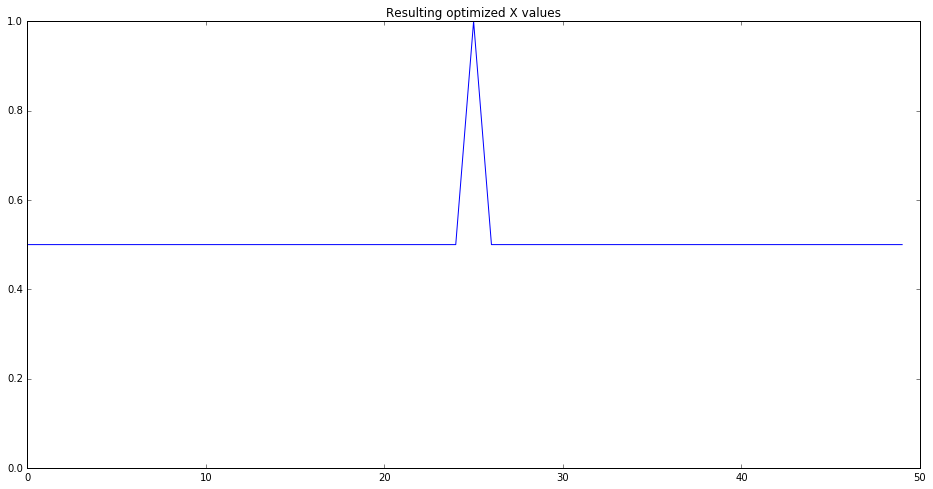

In [28]:
from optimize.snopt7 import SNOPT_solver
import numpy as np

inf = 1.0e20

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','blend_test1.out')

nsamples = 50

# 1. Set up decision variables
x0 = np.array([-1.0]*nsamples)

# 2. Set up the bounds on x
low_x = np.array([0.0]*nsamples)
upp_x = np.array([1.0]*nsamples)

# 3. Set up the objective function
def blend_test1_objF(status,x,needF,needG,cu,iu,ru):
    F = np.array([np.sum((x - 0.5)**2)]) # objective row
    return status, F

# 4. Set up bounds on F
low_F    = np.array([ -inf])
upp_F    = np.array([  inf])

# 5. Lets set up an equality constraint on one of the centerpoints
low_x[nsamples/2] = 1.0

# Matrix uses fortran numbering or something
ObjRow = 1

# We first solve the problem without providing derivative info
snopt.snopta(name='blend_test1',x0=x0,xlow=low_x,xupp=upp_x,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,
             usrfun=blend_test1_objF)

plt.plot(snopt.x)
plt.ylim([0,1])
plt.title("Resulting optimized X values")

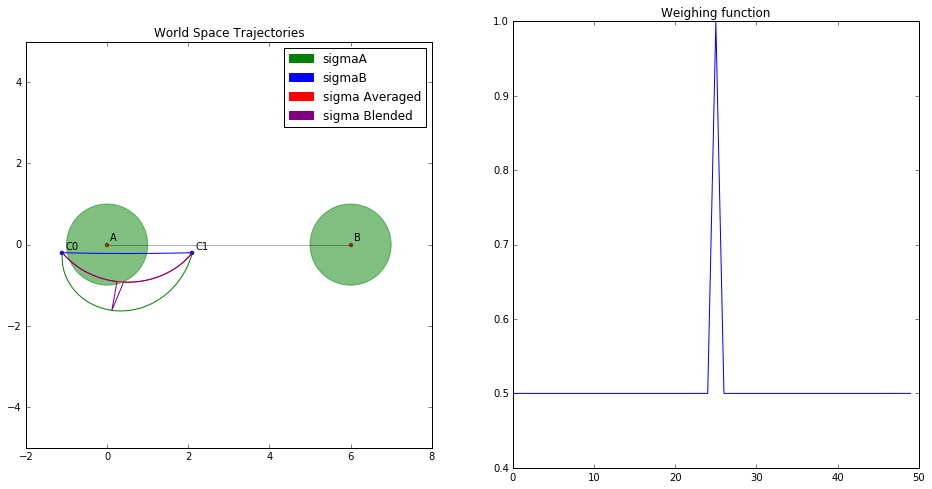

In [34]:
def precalculated_blendOptimized(u, sigma_i, sigma_j, i, j):
    blend = np.c_[snopt.x]
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer=precalculated_blendOptimized)

### Test 3: Express C4 Continuity Constraints



  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5049s


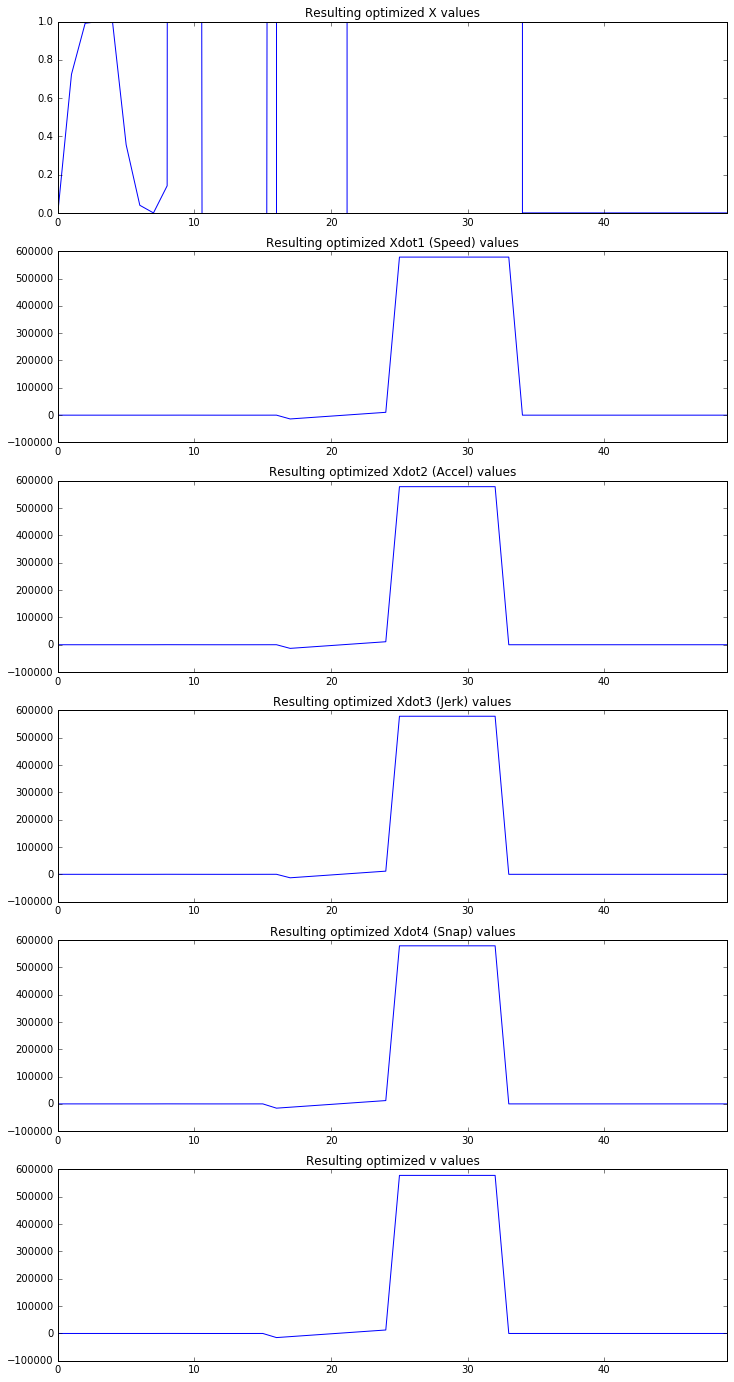

In [309]:
from optimize.snopt7 import SNOPT_solver
import numpy as np
import time

# Some important parameters here

nsamples = 50
dt = 0.001
xdot5_limit = 0.00001

inf = 1.0e20

lambda_snap = dt**4 # 1 means only minimize position variation. 0 means only minimize snap

# Solver Time!

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','blend_test1.out')


# 1. Set up decision variables

x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.0]*nsamples)
xdot2 = np.array([0.0]*nsamples)
xdot3 = np.array([0.0]*nsamples)
xdot4 = np.array([0.0]*nsamples)
v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

x0 = np.matrix((x,xdot1,xdot2,xdot3,xdot4,v)).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 2. Set up the bounds on x

low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
low_xdot1 = np.array([ -inf]*nsamples)
low_xdot2 = np.array([ -inf]*nsamples)
low_xdot3 = np.array([ -inf]*nsamples)
low_xdot4 = np.array([ -inf]*nsamples)
low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily

low_x[24] = 1.0 # with one silly constraint

xlow = np.matrix((low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v)).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
upp_xdot1 = np.array([ inf]*nsamples)
upp_xdot2 = np.array([ inf]*nsamples)
upp_xdot3 = np.array([ inf]*nsamples)
upp_xdot4 = np.array([ inf]*nsamples)
upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily

upp_x[37] = 0.0 # with another silly constraint

xupp = np.matrix((upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v)).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 3. Set up the objective function


M = np.array([
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1],
        [0,0,0,0,0]
    ])

N = np.array([0,0,0,0,1])


def blend_test1_objF(status,x,needF,needG,cu,iu,ru):
    
    stride = 6
    
    xM = x.reshape(6,-1)
    
    # our objective is the sum of
    # the L2 norm of our position error away from 0.5
    # the L2 norm of our 4th derivative error away from 0
    obj_pos  = np.sum( (xM[0,:] - 0.5)**2 * dt)
    obj_snap = np.sum( (xM[4,:]      )**2 * dt)  
    objective = obj_pos#lambda_snap*obj_snap
    #
    continuity_x = np.zeros((nsamples, 5))

    for i in range(nsamples-1):
        si  = xM[0:5,i]
        vi  = xM[5  ,i]
        si1 = xM[0:5,i+1]
        continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
   
    continuity_x = np.matrix(continuity_x).A1
        
    F = np.concatenate(
        ([objective],
         continuity_x))
    
    return status, F

# 4. Set up bounds on F

low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples)))
upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples)))

# Matrix uses fortran numbering or something
ObjRow = 1

# We first solve the problem without providing derivative info
a = time.time()

snopt.snopta(name='blend_test1',x0=x0,xlow=xlow,xupp=xupp,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,
             usrfun=blend_test1_objF)
b = time.time()

print "Solved in %.4fs" % (b - a)

pylab.rcParams['figure.figsize'] = 12, 24
gs = gridspec.GridSpec(6, 1, width_ratios=[1], height_ratios=[1,1,1,1,1,1]) 
fig = plt.figure()
f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])
f5 = fig.add_subplot(gs[4])
f6 = fig.add_subplot(gs[5])

f1.plot(snopt.x[0::6])
f1.set_ylim([0,1])
f1.set_xlim([0,nsamples-1])
f1.set_title("Resulting optimized X values")

f2.plot(snopt.x[1::6])
f2.set_ylim()
f2.set_xlim([0,nsamples-1])
f2.set_title("Resulting optimized Xdot1 (Speed) values")

f3.plot(snopt.x[2::6])
f3.set_ylim()
f3.set_xlim([0,nsamples-1])
f3.set_title("Resulting optimized Xdot2 (Accel) values")

f4.plot(snopt.x[3::6])
f4.set_ylim()
f4.set_xlim([0,nsamples-1])
f4.set_title("Resulting optimized Xdot3 (Jerk) values")

f5.plot(snopt.x[4::6])
f5.set_ylim()
f5.set_xlim([0,nsamples-1])
f5.set_title("Resulting optimized Xdot4 (Snap) values")

f6.plot(snopt.x[5::6])
f6.set_ylim()
f6.set_xlim([0,nsamples-1])
f6.set_title("Resulting optimized v values")


#### 

In [324]:
x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.1]*nsamples)
xdot2 = np.array([0.2]*nsamples)
xdot3 = np.array([0.3]*nsamples)
xdot4 = np.array([0.4]*nsamples)
v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

x = np.matrix((x,xdot1,xdot2,xdot3,xdot4,v)) # Interleave [x[0],xdot1[0],xdot2[0]...]

x[:,0] # get all the positions

matrix([[ 0.5],
        [ 0.1],
        [ 0.2],
        [ 0.3],
        [ 0.4],
        [ 0. ]])